In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import networkx as nx
import community
import itertools
import seaborn as sns
from sqlalchemy import create_engine, MetaData
import matplotlib.pyplot as plt
import sqlalchemy
import json
import inspect
from dateutil.parser import parse

%matplotlib inline

In [2]:
# Connect to DB
# follows django database settings format
DATABASES = {'production':{'NAME': '',
                           'USER': '',
                           'PASSWORD': '',
                           'HOST': '',
                           'PORT': ,
                          },}

# choose the database to use
db = DATABASES['production']

# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(user = db['USER'],
                                                                                          password = db['PASSWORD'],
                                                                                          host = db['HOST'],
                                                                                          port = db['PORT'],
                                                                                          database = db['NAME'],)

# create sqlalchemy engine
engine = create_engine(engine_string)

metadata = None
# try:
#     metadata = MetaData(bind=engine, reflect=True)
# except:
#     print('cant read metadata from DB')

data_path = ''

In [3]:
# SchemaDiscoveryDTO stores a list of tables in the input connection (tables of type Table) and list of dependencies between 
# the tables
class SchemaDiscoveryDTO:
    def __init__(self, name):
        self.name = name
        self.tables = []
        self.dependencies = None
        
# TableDTO contains a name, schema name (e.g. public), list of columns and list of entities (each entity is list of columns)
class TableDTO:
    def __init__(self, table_name):       
        self.name = table_name
        self.columns = []  
        self.entities = None
        self.size = None
        
# A column contains column name, raw_type(int, float, object) and type(label/free text/ numeric/ timestamp/ identifier code)
class ColumnDTO:
    def __init__(self, col_name, col_raw_type, col_type, is_pk, pk_source, is_fk, fk_source):
        self.name = col_name
        self.rawType = col_raw_type
        self.type = col_type
        self.isPK = is_pk
        self.PKsource = pk_source
        self.isFK = is_fk
        self.FKsource = fk_source
        
        
# A Entity contains a list of columns 
class EntityDTO:
    def __init__(self):
        self.columns = []
        
# TableRefDTO contain name of the table, name of the column, its cardinality and its relationship
class TableRefDTO:
    def __init__(self, table_name, column_name, cardinality_type, relationship_type):
        self.tableName = table_name
        self.columnName = column_name
        self.cardinalityType = cardinality_type
        self.relationshipType = relationship_type

# DependencyDTO contain two TableRefDTO; left and right that represent the dependency between two columns and the source of the dependency (from metadata or founde by us)
class DependencyDTO:
    def __init__(self, table_left, table_right, dependency_source):
        self.left = table_left
        self.right = table_right
        self.dependencySource = dependency_source
        
#Serealize result to json
class ObjectEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, "to_json"):
            return self.default(obj.to_json())
        elif hasattr(obj, "__dict__"):
            d = dict(
                (key, value)
                for key, value in inspect.getmembers(obj)
                if not key.startswith("__")
                and not inspect.isabstract(value)
                and not inspect.isbuiltin(value)
                and not inspect.isfunction(value)
                and not inspect.isgenerator(value)
                and not inspect.isgeneratorfunction(value)
                and not inspect.ismethod(value)
                and not inspect.ismethoddescriptor(value)
                and not inspect.isroutine(value)
            )
            return self.default(d)
        return obj

In [4]:
# Read data with given table.name as csv file and sample sample_size records if to_sample == True
def get_data(data_path, table, sample_size, to_sample=True):
    data = pd.read_csv(data_path + 'data/' + table.name + '.csv')

    if to_sample:
        how_many_take = min(table.size, sample_size)
        sampled_records = data.sample(n=how_many_take)

        return sampled_records
    
    return data


# Save schema_discovery object in given location
def save_schema_discovery(schema_discovery, schema_discovery_file_location):
    with open(schema_discovery_file_location, 'w', encoding='utf-8') as f:
        json.dump(schema_discovery, cls=ObjectEncoder, indent=2, fp=f, ensure_ascii=False)

In [5]:
def read_table_data(table_name, schema_discovery, engine, path_to_save_data):
    data = pd.read_sql_table(table_name, engine)
    if data.shape[0] > 1:
        data.to_csv(path_to_save_data, index=False)
        table = TableDTO(table_name)
        table.size = data.shape[0]
        schema_discovery.tables.append(table)
  
  
def get_schema_discovery_from_DB(engine, schema_name, data_path):  
    tables_names = engine.table_names() 
    schema_discovery = SchemaDiscoveryDTO(schema_name)
    threads_list = []
    tables_dict = {}
    for table_name in tables_names:
        path_to_save_data = data_path + 'data/' + table_name + '.csv'
        read_table_data(table_name, schema_discovery, engine, path_to_save_data)

    return schema_discovery

schema_discovery = get_schema_discovery_from_DB(engine, db['NAME'], data_path)

In [6]:
def is_date(string):
    try:
        parse(string, fuzzy=False)
        return True
    except:
        return False

# An auxiliary function that accepts basic columns_data (name & raw data type per column) and a sample of records (based on these columns) and calculates the final column type (label/free text/ numeric/ timestamp/ identifier code)
def calc_col_types(columns_data, sampled_records, table_metadata=None):   
    # Calculates data types from sampled_records and updating columns_data accordingly
    sample_size = sampled_records.shape[0] # the maximal number of unique values
    long_str = 200 # A column containing strings with more than this number of characters will be considered free text column
    label_threshold = 0.2 # labels are expected to contain unique values up to this percent of the number of non empty values
    text_threshold = 0.8 # Free texts are expected to contain unique values of at least this percent of the number of non empty values
    idenifier_threshold = 4 # Free texts are expected to contain at least this number of digits

    res = columns_data.copy()
    res['raw_type'] = res['raw_type'].astype(str)

    # Add number of unique values per column
    res['unique_vals'] = sampled_records.nunique().values

    # Add number of non-null values per column
    res['not_null_cnt'] = sampled_records.count(axis=0).values

    res['min_digits'] = 0 
    res['max_digits'] = 0 
    res['is_bool'] = [False] * len(res)
    res['is_str'] = [False] * len(res)
    res['is_date'] = [False] * len(res)
    for col in sampled_records.columns:
        col_vals_as_str = sampled_records[col].dropna().astype(str)
        # Add minimal number of characters
        min_str_len = col_vals_as_str.str.len().min()
        res.loc[res['col_name']==col, 'min_digits'] = min_str_len

        # Add maximal number of characters
        max_str_len = col_vals_as_str.str.len().max()
        res.loc[res['col_name']==col, 'max_digits'] = max_str_len

        if ('True' in col_vals_as_str.values) | ('False' in col_vals_as_str.values):
            res.loc[res['col_name']==col, 'is_bool'] = True

        if not any(any(sub_str.isdigit() for sub_str in main_str) for main_str in col_vals_as_str.values):
            res.loc[res['col_name']==col, 'is_str'] = True
            
        date_check = [is_date(val) for val in col_vals_as_str.values]    
        if all(date_check):
            res.loc[res['col_name']==col, 'is_date'] = True    
            
    res['col_type'] = res['raw_type'].copy()

    # Checks if the column is numeric
    is_numeric = np.vectorize(lambda x: True if any(sub_str in str(x) for sub_str in ['int', 'float']) else False)
    res['is_numeric'] = is_numeric(res['raw_type']) 

    # Checks if the column is int
    is_int = np.vectorize(lambda x: True if 'int' in str(x) else False)
    res['is_int'] = is_int(res['raw_type'])

    # Recognizing identifing keys as unique numbers or codes
    msk_id_code = ((res['is_str']==False) & (res['is_bool']==False) & (res['min_digits'] == res['max_digits']) &\
                   (res['min_digits']>=idenifier_threshold) & ((res['is_int']==True) | (res['raw_type'] == 'object')))
    res.loc[msk_id_code,'col_type'] = 'identifier code' 

    # Recognizing labels as repeating short texts
    msk_lable = ((res['is_bool']==False) & (res['col_type'] == res['raw_type']) & (res['unique_vals']<res['not_null_cnt']*label_threshold) &\
                 (res['raw_type'] == 'object'))
    res.loc[msk_lable,'col_type'] = 'label' 

    # Recognizing numeric columns as numeric columns that are not identifiers
    msk_numeric = (res['is_bool']==False) & (res['col_type'] == res['raw_type']) & (res['is_numeric'])
    res.loc[msk_numeric,'col_type'] = 'numeric'

    # Recognizing free texts as unique or long texts
    msk_free_text = ((res['is_bool']==False) & (res['col_type'] == res['raw_type']) & \
                     ((res['is_str']==True) | (((res['unique_vals']>=res['not_null_cnt']*text_threshold) | (res['max_digits']>=long_str)) & \
                                               (res['raw_type'] == 'object'))))
    res.loc[msk_free_text,'col_type'] = 'free text' 

    # Recognizing bool columns as bool columns
    msk_bool = (res['is_bool'])
    res.loc[msk_bool,'col_type'] = 'bool'
    
    # Recognizing dates
    msk_date = ((res['raw_type'].str.contains('time')) | (res['is_date'] == True))
    res.loc[msk_date,'col_type'] = 'timestamp'
    
    # Recognizing Primery Key
    res['is_pk'] = False
    res['pk_source'] = 'None'
    if table_metadata != None:
        for col in [col for col in table_metadata.columns if ((col.name in columns_data['col_name'].values) & (col.primary_key))]:
            res.loc[res['col_name'] == col.name, 'is_pk'] = True
            res.loc[res['col_name'] == col.name, 'pk_source'] = 'Metadata'
    
    else:
        msk_pk = ((res['col_type']=='identifier code') & (res['unique_vals'] == res['not_null_cnt']) & (res['unique_vals'] == sample_size))
        res.loc[msk_pk, 'is_pk'] = True 
        res.loc[msk_pk, 'pk_source'] = 'Discovered' 

        num_pk = res.loc[res['is_pk'] == True].shape[0]

        # If no PK, search for combinations of identifier code columns that create x unqiue keys where x is the size of the data
        if num_pk == 0:
            id_code_cols = res.loc[(res['col_type'] == 'identifier code') & (res['not_null_cnt'] == sample_size)]['col_name'].values
            for pk_len in range(2, len(id_code_cols)+1):
                all_possible_combination = itertools.combinations(id_code_cols, pk_len)
                for pk_group in all_possible_combination:
                    num_unqiue_vals = len(sampled_records.groupby(list(pk_group)).groups)
                    if num_unqiue_vals == sample_size:
                        res.loc[res['col_name'].isin(pk_group), 'is_pk'] = True
                        res.loc[res['col_name'].isin(pk_group), 'pk_source'] = 'Discovered'
                        pk_len = len(id_code_cols)+1
                        break 
                        
        # If more then one column acts as PK (by itself, not as combination of columns) we need to choose only one of 
        # them as PK and the others will be regular identifier code columns (there is no additional information in keeping all as PK)
        elif num_pk > 1:
            all_pk_cols = res.loc[res['is_pk'] == True]['col_name']
            res.loc[res['col_name'].isin(all_pk_cols[1:]), 'is_pk'] = False
            res.loc[res['col_name'].isin(all_pk_cols[1:]), 'pk_source'] = 'None'
    
    return res

# Extracting the list of columns with column names and their raw data types from table with given table.table_name
def get_columns(table, data_path, sample_size, table_metadata=None):  
    sampled_records = get_data(data_path, table, sample_size)
  
    cols_df = pd.DataFrame({'col_name':sampled_records.dtypes.index.values, 'raw_type':sampled_records.dtypes.values})
    cols_data = calc_col_types(cols_df, sampled_records, table_metadata)
  
    table.columns = []
    for idx, col in cols_data.iterrows():
        # filter free text columns        
        if str(col['col_type']) != 'free text':
            table.columns.append(ColumnDTO(col['col_name'], str(col['raw_type']), str(col['col_type']), col['is_pk'], col['pk_source'], False, 'None'))
        
def get_tables_cols(schema_discovery, data_path, sample_size, metadata=None):    
    threads_list = []
    for table in schema_discovery.tables:
        if metadata != None:
            table_metadata = metadata.tables[table.name]
        else:
            table_metadata = None 
        get_columns(table, data_path, sample_size, table_metadata)
        
get_tables_cols(schema_discovery, data_path, 1000, metadata)

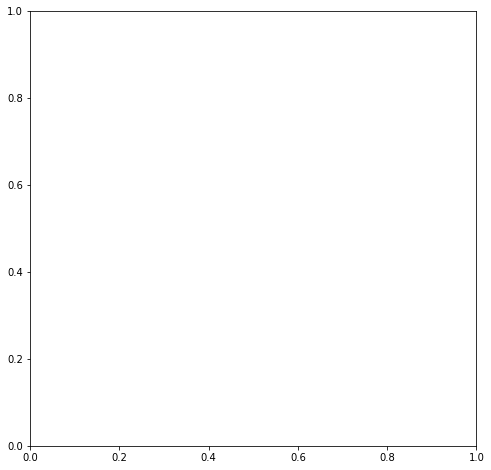

finish finding clusters for table h_contract_activity_data, num of clusters: 0


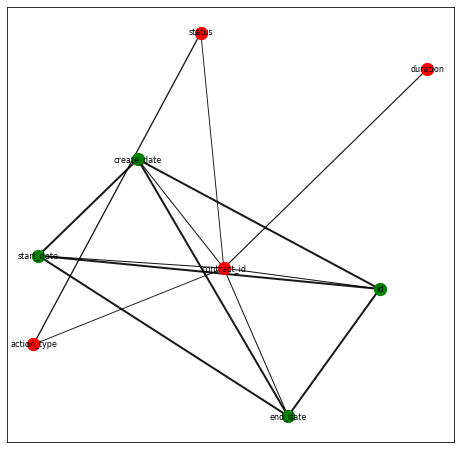

finish finding clusters for table h_contract_activity, num of clusters: 2


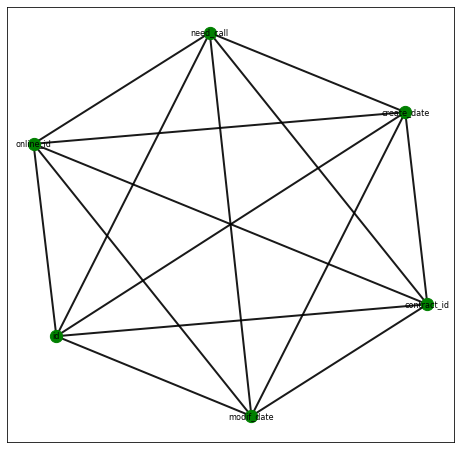

finish finding clusters for table online_contract_data, num of clusters: 1


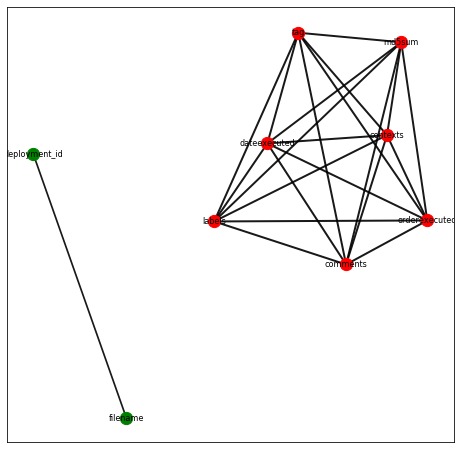

finish finding clusters for table databasechangelog, num of clusters: 2


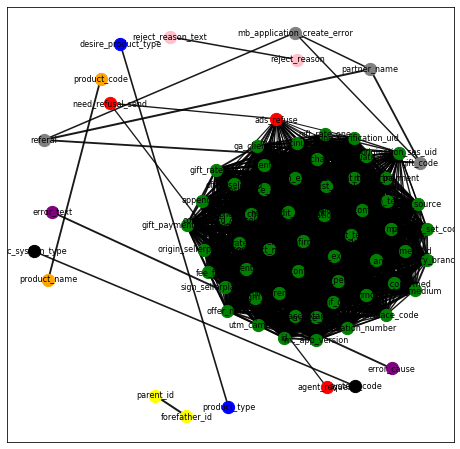

finish finding clusters for table contract, num of clusters: 9


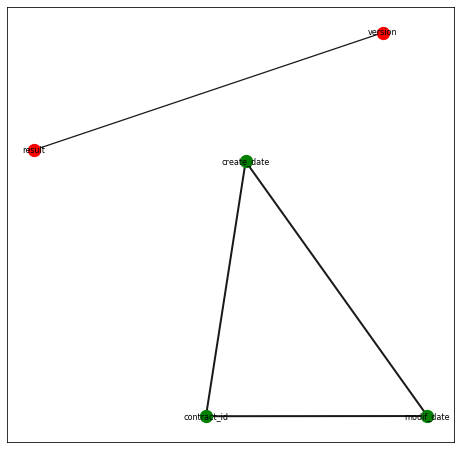

finish finding clusters for table delay_contract_try, num of clusters: 2


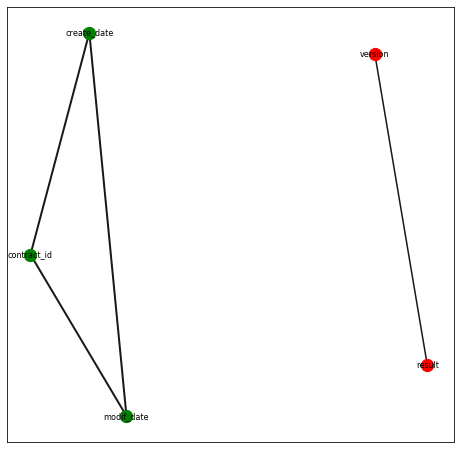

finish finding clusters for table auto_approve_contract_try, num of clusters: 2


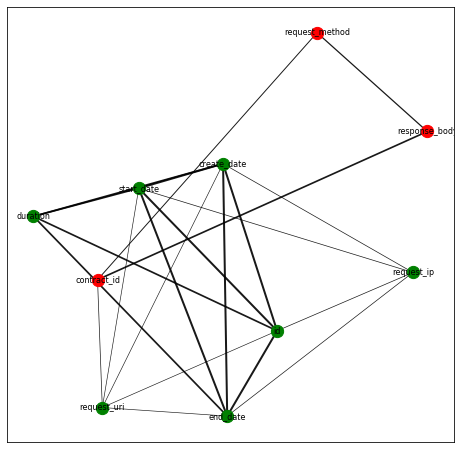

finish finding clusters for table h_api_activity, num of clusters: 2


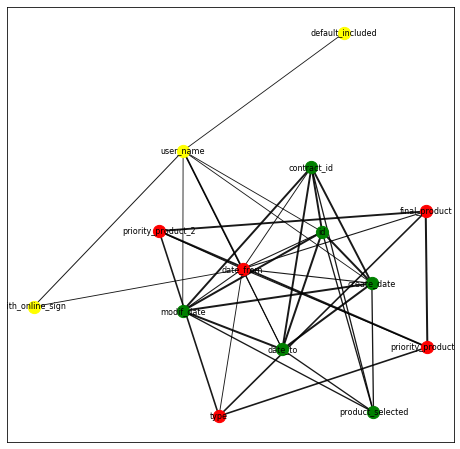

finish finding clusters for table service, num of clusters: 3


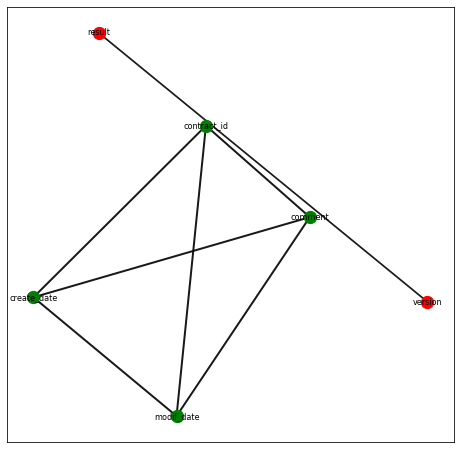

finish finding clusters for table cancel_contract_try, num of clusters: 2


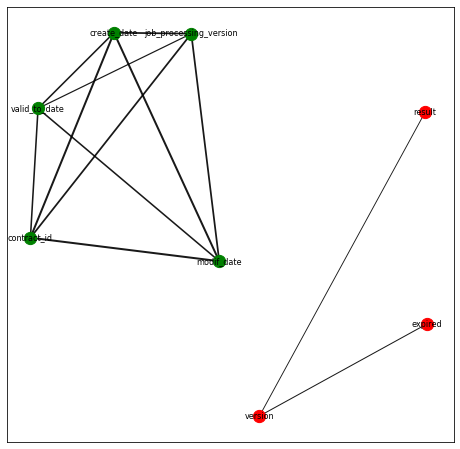

finish finding clusters for table follow_contract_try, num of clusters: 2


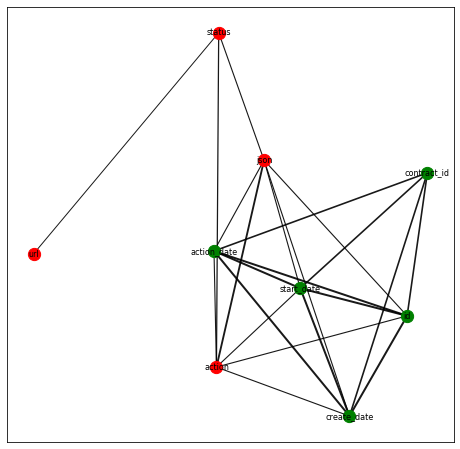

finish finding clusters for table h_client_activity, num of clusters: 2


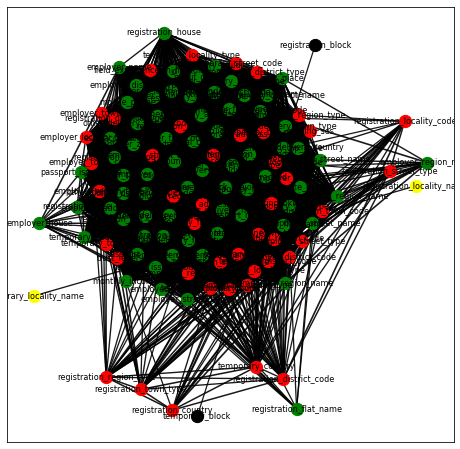

finish finding clusters for table client, num of clusters: 4


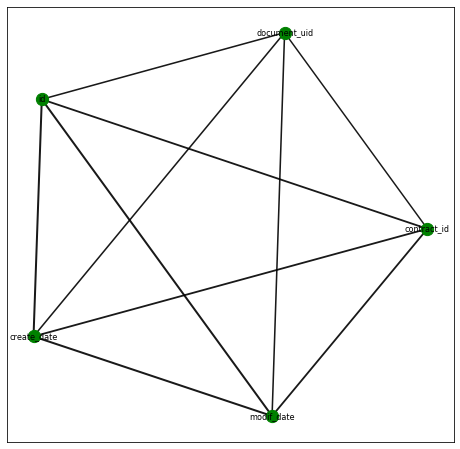

finish finding clusters for table income_confirmation, num of clusters: 1


In [7]:
# Transform all columns values to categorical values (e.g. from ['israel', 'usa', 'israel', 'spain'] to [1, 2, 1, 3])
def to_categorical(data, columns_names):
    le = preprocessing.LabelEncoder()
    categorical_cols = {}
    for col_name in columns_names:
        col_real_vals = data[col_name].values
        col_real_vals = ['None' if val is None else val for val in col_real_vals]
        categorical_cols[col_name] = le.fit_transform(col_real_vals)
    return categorical_cols

# Calculate correlation matrix; extracts internal dependencies between column pairs that appear in data
# Matrix corr_matrix contain the dependencies estimation between col_1 and col_2 (where col_1 != col_2) using mutual information measure
def get_correlation_matrix(table, data): 
    data_col_names = [col.name for col in table.columns]
    categorical_cols = to_categorical(data, data_col_names)
    all_possible_cols_combinations = [x for x in itertools.combinations(data_col_names, 2)]
    
    corr_matrix = pd.DataFrame(columns=data_col_names, 
                               index=data_col_names, 
                               data=np.zeros((len(data_col_names), len(data_col_names))))
    
    for col_tuple in all_possible_cols_combinations:
        col_1 = col_tuple[0]
        col_2 = col_tuple[1]
        
        cat_col_1 = categorical_cols[col_1]
        cat_col_2 = categorical_cols[col_2]
        
        # Calculate the Information Gain of target columns given the source column
        mutulal_info = metrics.normalized_mutual_info_score(cat_col_1, cat_col_2)
        corr_matrix.loc[col_1, col_2] = mutulal_info
        corr_matrix.loc[col_2, col_1] = mutulal_info

#     # plot heatmap of correlation matrix
#     sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True)

    return corr_matrix
    
    
# Create network graph using networkx package based on correlation matrix created by get_correlation_matrix function on given data
# when filter_col is True -> correlation value is set to 0 for columns tuple with correlation value lower then mean correlation value 
def get_network_graph(corr_matrix, filter_col=True):
    links = corr_matrix.stack().reset_index()
    links.columns = ['var1', 'var2','value']

    # Remove self correlation
    links_filtered = links.loc[links['var1'] != links['var2']]

    if filter_col:
        # Keep only correlation over a threshold (the mean correlation value)
        mean_corr = links_filtered.loc[links_filtered['value'] > 0]['value'].mean()
        links_filtered = links_filtered.loc[links_filtered['value'] > mean_corr]
        
    # Build the graph
    G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')

#     # Plot the network:
#     nx.draw_circular(G, with_labels=True, node_size=200, font_size=10)

    return G

# Detects communities in the graph
# The communities detection method we use can be one of the next communities detection methods:
# 1. GN - girvan_newman 
# 2. best- best_partition (based on Louvain algorithm)
def detect_communities(G, community_method='best'):
    if community_method == 'GN':
        comp = girvan_newman(G)
        for communities in itertools.islice(comp, int(0.3*len(G.nodes))):
            clusters = tuple(sorted(c) for c in communities)

    elif community_method == 'best':
        communities = community.best_partition(G)

        clusters = []
        cluster_dict = {}
        for i in range(len(set([val for val in communities.values()]))):
            curr_cluster = [key for key, val in communities.items() if val == i]
            clusters.insert(i, curr_cluster)
            for node in curr_cluster:
                cluster_dict[node] = i
                
        nx.set_node_attributes(G, cluster_dict, 'cluster')
     
    return clusters

# Plot the entities we found as communities on network (features) graph
def plot_communty_network(G, path_to_save_plot, with_labels=True):
    plt.figure(figsize=(8,8))
    pos = nx.spring_layout(G, k=2)
    node_colors = ['green', 'red', 'yellow', 'black', 'blue', 'orange', 'pink', 'purple', 'gray', 'brown']
    
#     edge_labels = nx.get_edge_attributes(G, 'value')
#     for key_tuple in edge_labels:
#       edge_labels[key_tuple] = round(edge_labels[key_tuple], 3)

#     nx.draw_networkx_edges(G, pos, width=1, alpha=0.9)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
   
    edges = G.edges()
    weights = [G[u][v]['value']*2 for u,v in edges]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.9)
    
    for node, node_att_dict in G.nodes(data=True):
        cluster_idx = node_att_dict['cluster']
        color = node_colors[cluster_idx%len(node_colors)]
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_size=150)
        if with_labels:
            nx.draw_networkx_labels(G, pos, {node:node}, font_size=8)

    nx.write_gexf(G, path_to_save_plot + '.gexf')
    plt.savefig(path_to_save_plot)  
    plt.show()

# Main function that uses all previous functions to detect main entities for each table in schema_discovery
def find_entities(schema_discovery, data_path, sample_size=10000):
    threads_list = []
    results_dict = {}
    for table in schema_discovery.tables:
        sampled_records = get_data(data_path, table, sample_size)
        
        corr_matrix = get_correlation_matrix(table, sampled_records)
        G = get_network_graph(corr_matrix)
        clusters = detect_communities(G)
        plot_communty_network(G, data_path + 'plots/' + table.name)
        print('finish finding clusters for table ' + table.name + ', num of clusters: ' + str(len(clusters)))
        
        table.entities = []
        for cluster in clusters:
            entity = EntityDTO()
            entity.columns = cluster
            table.entities.append(entity)
            
    return G
            
G = find_entities(schema_discovery, data_path)

In [8]:
# Concatinate number of columns to one unique PK column - done for compersion between PK of tables that build from number
# of columns
def combain_pk_columns(data, pk_list):
    data['concat_pk_col'] = data[[col.name for col in pk_list]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    pk_raw_types = [col.rawType for col in pk_list]
    pk_raw_types.sort()  
    new_pk_list = [ColumnDTO(name='concat_pk_col', 
                             rawType='_'.join(pk_raw_types), 
                             type='identifier code',
                             isPK=True,
                             PKsource='Discovered',
                             isFK=False,
                             FKsource='None')]
    
    return data, new_pk_list

# Get the cardinality of column given the data. cardinality can get one of the next values:
# '1': each unique value of this column appear only once
# 'M': there is at least one unqiue value of this column that appear more then one time
def get_cardinality(data, col_name):
    map_cardinalty = lambda x : 'One' if (x == 1) else 'Many' 
    
    cardinality = data.dropna(subset=[col_name]).groupby(col_name).count().max().max()
    cardinality = map_cardinalty(cardinality)
    
    return cardinality

# Search table object with given table_name in schema_discovery.tables_list. If there is no table with this name- return None
def get_table_by_name(schema_discovery, table_name):
    for table in schema_discovery.tables:
        if table.name == table_name:
            return table
    return None

# Change the type of each column that is a foreign key to 'FK' type
def set_col_keytype_to_FK(table, col_name, FK_source):
    for col in table.columns:
        if (col.name == col_name) & (col.isPK == False) & (col.isFK == False):
            col.isFK = True
            col.FKsource = FK_source

# Get the relationship between two columns; Contained, Contains, Partial Overlap, Equel (same values), or None if there is
# no relationship between this two columns
def get_relationship_type(data_1, data_2, col_1, col_2):
    col_name_1 = col_1 + '_1'
    col_name_2 = col_2 + '_2'                

    vals_col_1 = pd.DataFrame(data=data_1[col_1].dropna().unique(), columns=[col_name_1])
    vals_col_2 = pd.DataFrame(data=data_2[col_2].dropna().unique(), columns=[col_name_2])

    col_1_relationship = None
    col_2_relationship = None

    join_on_cols = pd.merge(vals_col_1, vals_col_2, left_on=col_name_1, right_on=col_name_2, how='inner')

    if (join_on_cols.shape[0] == len(vals_col_1)) & (join_on_cols.shape[0] == len(vals_col_2)):
        col_1_relationship = 'Equel'
        col_2_relationship = 'Equel'
    else:
        if join_on_cols.shape[0] == len(vals_col_1):
            col_1_relationship = 'Contained'
            col_2_relationship = 'Contains'
        elif join_on_cols.shape[0] == len(vals_col_2):
            col_1_relationship = 'Contains'
            col_2_relationship = 'Contained'
        elif join_on_cols.shape[0] > 0:
            col_1_relationship = 'Overlap'
            col_2_relationship = 'Overlap'
            
    return col_1_relationship, col_2_relationship
            
# Extracts external dependencies between tabels pairs
# dataframe connected_tabels contains names of the two connected attributes, their tabels names, and the type of 
# dependency (1:1, 1:M, M:1, M:N)
def find_foreign_keys(table_1, table_2, data_path):  
    tables_dependencies = []        
    data_1 = get_data(data_path, table_1, 0, to_sample=False)
    data_2 = get_data(data_path, table_2, 0, to_sample=False)

    pk_table_1 = [col for col in table_1.columns if col.isPK]
    pk_table_2 = [col for col in table_2.columns if col.isPK]
    identifier_code_cols_1 = [col for col in table_1.columns if ((col.type == 'identifier code') & (not col.isPK))]
    identifier_code_cols_2 = [col for col in table_2.columns if ((col.type == 'identifier code') & (not col.isPK))]
    
    if (len(pk_table_1) == 0) & (len(pk_table_2) == 0):
        return tables_dependencies
    
    # If the tables have diffrent size of PK we cant comper bwtween them -> check dependencies only between PK of size 1 and 
    # identifier code columns
    if (len(pk_table_1) != len(pk_table_2)):
        if (len(pk_table_1) > 1) & (len(pk_table_2) > 1):
            return tables_dependencies
        elif len(pk_table_1) > 1:
            pk_table_1 = []
        elif len(pk_table_2) > 1:
            pk_table_2 = []
    
    # If the tables have same size of PK then we can comper them- first we concatinate all pk columns to one unique column
    if (len(pk_table_1) == len(pk_table_2)) & (len(pk_table_1) > 1):
        data_1, pk_table_1 = combain_pk_columns(data_1, pk_table_1)
        data_2, pk_table_2 = combain_pk_columns(data_2, pk_table_2)    

    pk_identifier_code_cols_1 = pk_table_1 + identifier_code_cols_1
    pk_identifier_code_cols_2 = pk_table_2 + identifier_code_cols_2
    
    for col_1 in pk_identifier_code_cols_1:
        for col_2 in pk_identifier_code_cols_2:
            if (not col_1.isPK) & (not col_2.isPK):
                continue
            if col_1.rawType == col_2.rawType:
                col_1_relationship, col_2_relationship = get_relationship_type(data_1, data_2, col_1.name, col_2.name)
                        
                if col_1_relationship != None:                    
                    cardinality_col_1 = get_cardinality(data_1, col_1.name)
                    cardinality_col_2 = get_cardinality(data_2, col_2.name)
                    
                    ref_left = TableRefDTO(table_name=table_1.name, column_name=col_1.name, cardinality_type=cardinality_col_1, relationship_type=col_1_relationship)
                    ref_right = TableRefDTO(table_name=table_2.name, column_name=col_2.name, cardinality_type=cardinality_col_2, relationship_type=col_2_relationship)
                    dependency = DependencyDTO(ref_left, ref_right, dependency_source='Discovered')
                    tables_dependencies.append(dependency)
                    
                    set_col_keytype_to_FK(table_1, col_1.name, 'Discovered')
                    set_col_keytype_to_FK(table_2, col_2.name, 'Discovered')
                    
#                     print(dependency.left.tableName+'.'+dependency.left.columnName+'_'+dependency.left.cardinalityType+'_'+dependency.left.relationshipType+'  '+\
#                           dependency.right.tableName+'.'+dependency.right.columnName+'_'+dependency.right.cardinalityType+'_'+dependency.right.relationshipType+'  '+dependency.dependencySource)

    return tables_dependencies

                    
# Iterate over thr final dependencies_list and remove from it duplicate dependencies
def remove_duplicate_dependencies(dependencies_list):
    all_dep_hash = []
    new_dependencies_list = []
    for dep in dependencies_list:
        ref_hash_left = dep.left.tableName + '_' + dep.left.columnName 
        ref_hash_right = dep.right.tableName + '_' + dep.right.columnName
        
        left_right = ref_hash_left + '_' + ref_hash_right
        right_left = ref_hash_right + '_' + ref_hash_left
        
        if (left_right not in all_dep_hash) & (right_left not in all_dep_hash):
            new_dependencies_list.append(dep)
            all_dep_hash = all_dep_hash + [left_right, right_left]
        
    return new_dependencies_list

# Change all 'identifier code' type columns that didnt recognized as PK or FK to 'lable' type
def change_identifier_code_to_lable(schema_discovery):
    for table in schema_discovery.tables:
        for col in table.columns:
            if ((not col.isPK) & (not col.isFK) & (col.type == 'identifier code')):
                col.type = 'lable'
            
# Iterate over known dependencies and add them to dependencies_list that evntually will be returned and added to 
# schema_discovery.dependencies
def add_table_dependencies_from_metadata(table, table_metadata, schema_discovery, data_path):
    table_constraints = list(table_metadata.constraints)
    dependencies_list = []

    for i in range(len(table_constraints)):
        if type(table_constraints[i]) == sqlalchemy.sql.schema.ForeignKeyConstraint:
            table_columns_with_foreign_key = []
            
            # get foreign keys names as thay appear in the current table
            for col in table_constraints[i].columns:
                table_columns_with_foreign_key.append((str(col.table.name), col.name))
            
            # get foreign keys names as thay appear in the foreign table
            all_foreign_keys = [(elemnt.column.table.name, elemnt.column.name) for elemnt in table_constraints[i].elements]
            
            if len(table_columns_with_foreign_key) != len(all_foreign_keys):
                return dependencies_list
            
            # iterate over all pairs of columns we found (current table columns, foreign table colum)
            for i in range(len(table_columns_with_foreign_key)):
                table_col = table_columns_with_foreign_key[i]
                foreign_col = all_foreign_keys[i]
                
                foreign_table = get_table_by_name(schema_discovery, foreign_col[0])
                if foreign_table == None:
                    return dependencies_list
                
                table_data = get_data(data_path, table, 0, to_sample=False)
                foreign_table_data = get_data(data_path, foreign_table, 0, to_sample=False)
                
                cardinality_left = get_cardinality(table_data, table_col[1])
                cardinality_right = get_cardinality(foreign_table_data, foreign_col[1])
                
                col_1_relationship, col_2_relationship = get_relationship_type(table_data, foreign_table_data, table_col[1], foreign_col[1])
                
                ref_left = TableRefDTO(table_name=table_col[0], column_name=table_col[1], cardinality_type=cardinality_left, relationship_type=col_1_relationship)
                ref_right = TableRefDTO(table_name=foreign_col[0], column_name=foreign_col[1], cardinality_type=cardinality_right, relationship_type=col_2_relationship)
                dependency = DependencyDTO(ref_left, ref_right, dependency_source='Metadata')
    
                dependencies_list.append(dependency)
                
                set_col_keytype_to_FK(table, table_col[1], 'Metadata')
                set_col_keytype_to_FK(foreign_table, foreign_col[1], 'Metadata')

#                 print(dependency.left.tableName+'.'+dependency.left.columnName+'_'+dependency.left.cardinalityType+'_'+dependency.left.relationshipType+'  '+\
#                       dependency.right.tableName+'.'+dependency.right.columnName+'_'+dependency.right.cardinalityType+'_'+dependency.right.relationshipType+'  '+dependency.dependencySource)
                    
    return dependencies_list 


# Main function; extract dependencies between each possible combonation of two table from schema_discovery
def get_external_dependencies(schema_discovery, data_path, metadata=None):
    all_tables_dependencies = []
    if metadata != None:
        for table in schema_discovery.tables:
            table_metadata = metadata.tables[table.name]
            table_dep_from_metadata = add_table_dependencies_from_metadata(table, table_metadata, schema_discovery, data_path)
            all_tables_dependencies = all_tables_dependencies + table_dep_from_metadata
    
    all_possible_table_combinations = [x for x in itertools.combinations(schema_discovery.tables, 2)]

    for tables_tupple in all_possible_table_combinations:
        table_1 = tables_tupple[0]
        table_2 = tables_tupple[1]
        
        tables_dependencies = find_foreign_keys(table_1, table_2, data_path)
        all_tables_dependencies = all_tables_dependencies + tables_dependencies
      
    all_tables_dependencies = remove_duplicate_dependencies(all_tables_dependencies)
    schema_discovery.dependencies = all_tables_dependencies
    change_identifier_code_to_lable(schema_discovery)
    
get_external_dependencies(schema_discovery, data_path, metadata)

In [10]:
# for each table print columns names, types, raw types, isPK and isFK

for table in schema_discovery.tables:
    print(table.name)
    for col in table.columns:
        print(col.name + ' ' +  col.type + ' ' + col.rawType + ' ' + str(col.isPK) + ' ' + str(col.PKsource) + ' ' + str(col.isFK) + ' ' + str(col.FKsource))
    print('')

h_contract_activity_data
id identifier code int64 True Discovered False None
h_contract_activity_id lable int64 False None False None
create_date timestamp object False None False None

h_contract_activity
id numeric int64 False None False None
contract_id identifier code object False None True Discovered
action_type label object False None False None
status label object False None False None
result label object False None False None
create_date timestamp object False None False None
end_date timestamp object False None False None
start_date timestamp object False None False None
duration numeric float64 False None False None

online_contract_data
id timestamp int64 False None False None
contract_id identifier code object True Discovered False None
online_id numeric float64 False None False None
create_date timestamp object False None False None
modif_date timestamp object False None False None
channel numeric float64 False None False None
create_error_code numeric float64 False None F

In [11]:
# for each table print its entities

for table in schema_discovery.tables:
    print(table.name)
    print('NUMBER OF ENTITIES:', len(table.entities))
    for entity in table.entities:
        print(entity.columns)
    print('')

h_contract_activity_data
NUMBER OF ENTITIES: 0

h_contract_activity
NUMBER OF ENTITIES: 2
['id', 'create_date', 'end_date', 'start_date']
['contract_id', 'action_type', 'status', 'duration']

online_contract_data
NUMBER OF ENTITIES: 1
['id', 'contract_id', 'online_id', 'create_date', 'modif_date', 'need_call']

databasechangelog
NUMBER OF ENTITIES: 2
['filename', 'deployment_id']
['dateexecuted', 'orderexecuted', 'md5sum', 'comments', 'tag', 'contexts', 'labels']

contract
NUMBER OF ENTITIES: 9
['id', 'month_payment', 'credit_amount', 'payment_num', 'rate', 'offer_num', 'eqn_application_number', 'contract_number', 'sellerplace_code', 'consent_uid', 'create_date', 'modif_date', 'sign_sellerplace_code', 'appended', 'nmd', 'nmd_changed', 'cc_sign_expired', 'dbo_exists', 'fee_fz', 'code_word_canceled', 'product_set_code', 'offer_selected', 'dc_registry_branch_id', 'stop_list_terrorist', 'stop_list_obnal', 'reject_sent_to_partner', 'mgm_id', 'income_confirmed', 'phone_verification_uid', 'ph

In [12]:
# print all dependencies between tables

i = 0
for dependency in schema_discovery.dependencies:
    print(dependency.left.tableName+'.'+dependency.left.columnName+'_'+dependency.left.cardinalityType+'_'+dependency.left.relationshipType+'  '+\
          dependency.right.tableName+'.'+dependency.right.columnName+'_'+dependency.right.cardinalityType+'_'+dependency.right.relationshipType+'  '+dependency.dependencySource)
    i+=1
print(i)

h_contract_activity.contract_id_Many_Overlap  online_contract_data.contract_id_One_Overlap  Discovered
h_contract_activity.contract_id_Many_Overlap  contract.id_One_Overlap  Discovered
h_contract_activity.contract_id_Many_Overlap  delay_contract_try.contract_id_One_Overlap  Discovered
h_contract_activity.contract_id_Many_Contains  auto_approve_contract_try.contract_id_One_Contained  Discovered
h_contract_activity.contract_id_Many_Contains  cancel_contract_try.contract_id_One_Contained  Discovered
h_contract_activity.contract_id_Many_Overlap  follow_contract_try.contract_id_One_Overlap  Discovered
h_contract_activity.contract_id_Many_Contains  client.contract_id_One_Contained  Discovered
online_contract_data.contract_id_One_Contained  contract.id_One_Contains  Discovered
online_contract_data.contract_id_One_Contains  contract.parent_id_One_Contained  Discovered
online_contract_data.contract_id_One_Contains  contract.forefather_id_Many_Contained  Discovered
online_contract_data.contract_

In [13]:
save_schema_discovery(schema_discovery,'./schema_discovery_without_metadata.json')